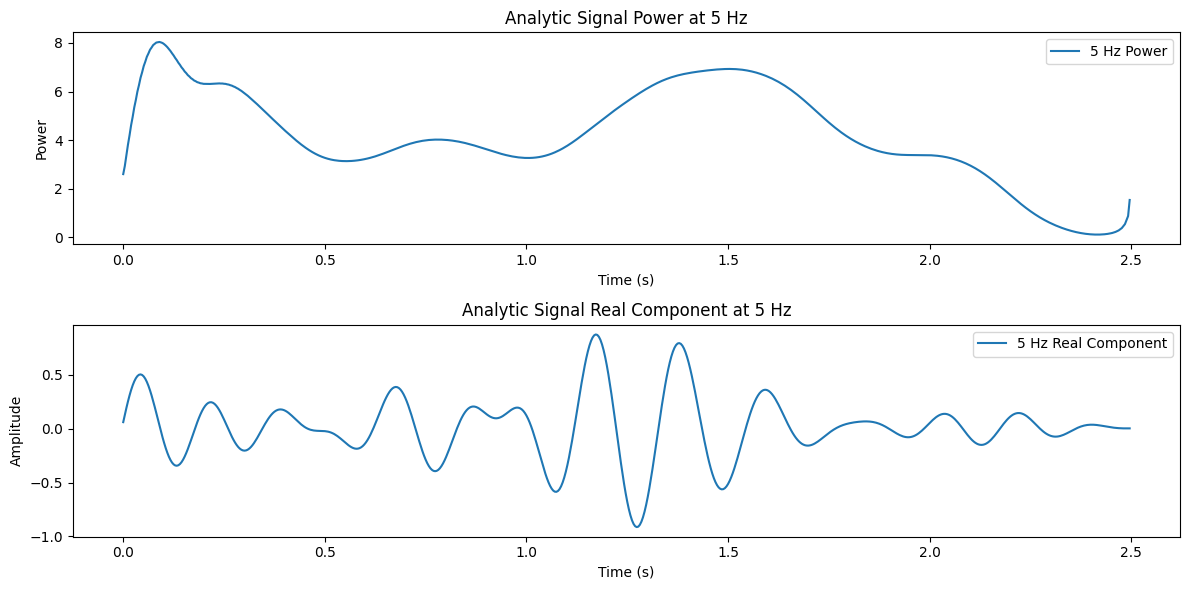

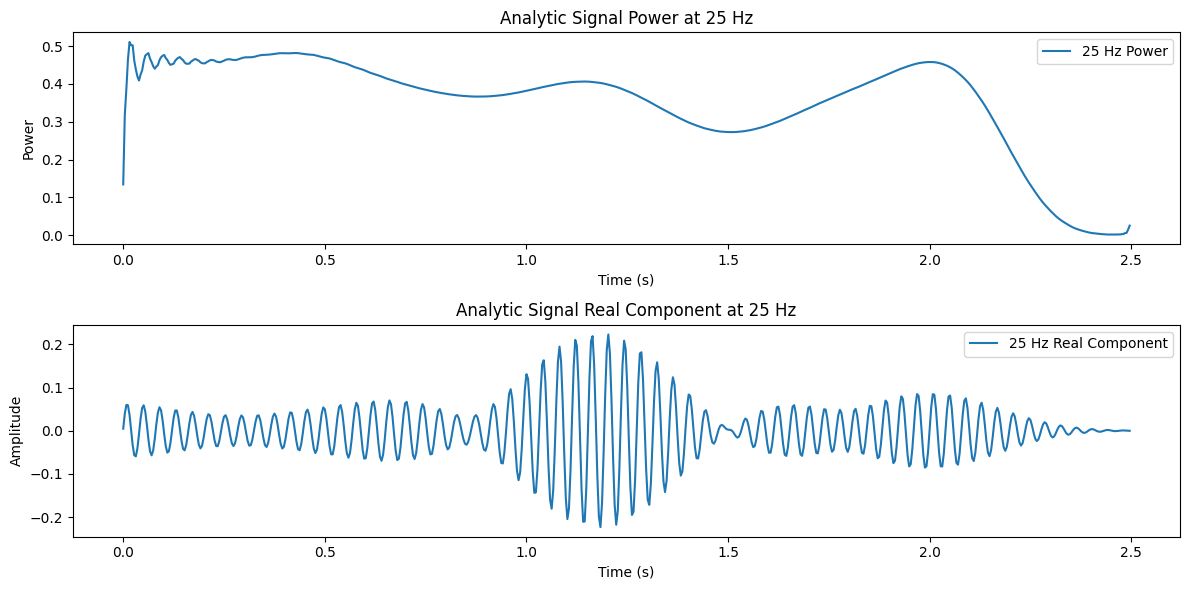

In [26]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
import scipy.io

# Load the MATLAB file
mat_file_path = 'sampleEEGdata.mat'
mat_data = scipy.io.loadmat(mat_file_path)
eeg_data = mat_data['EEG']

# Access the data and channel location fields
eeg_data_field = eeg_data['data'][0, 0]
chanlocs_field = eeg_data['chanlocs'][0, 0]
sampling_rate = eeg_data['srate'][0, 0][0, 0]
channel_labels = [chanlocs_field['labels'][0][i][0] for i in range(chanlocs_field['labels'].shape[1])]
cz_index = channel_labels.index('Cz')
cz_data = eeg_data_field[cz_index, :, :]  # Data is in the format [channels, times, trials]

# Bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

# # Compute FFT and IFFT to get analytic signal
# def compute_fft_ifft(data, fs):
#     fft_data = fft(data, axis=0)
#     complex_fft_data = fft_data * (1j)
#     positive_frequencies = np.arange(0, fft_data.shape[0] // 2)
#     negative_frequencies = np.arange(fft_data.shape[0] // 2, fft_data.shape[0])
#     complex_fft_data[positive_frequencies] =  positive_frequencies+-1j* complex_fft_data(positive_frequencies)#np.exp(-1j * np.pi / 2)
#     complex_fft_data[negative_frequencies] =positive_frequencies+1j* complex_fft_data (positive_frequencies) #np.exp(1j * np.pi / 2)
#     analytic_signal = ifft(complex_fft_data, axis=0)
#     return analytic_signal




def compute_fft_ifft(data, fs):
    # Compute the FFT of the input data
    fft_data = fft(data, axis=0)
    
    # Create a copy of the fft data to construct the analytic signal
    complex_fft_data = np.zeros_like(fft_data, dtype=complex)
    
    # Find the indices for the positive and negative frequencies
    positive_frequencies = np.arange(0, fft_data.shape[0] // 2 + 1)
    negative_frequencies = np.arange(fft_data.shape[0] // 2 + 1, fft_data.shape[0])
    
    # Assign the positive frequencies and zero out the negative frequencies
    complex_fft_data[positive_frequencies] = fft_data[positive_frequencies]
    complex_fft_data[negative_frequencies] = 0
    
    # Compute the IFFT of the complex FFT data to get the analytic signal
    analytic_signal = ifft(complex_fft_data, axis=0)
    
    return analytic_signal


# Analysis parameters
bandwidth = 3  # 3 Hz bandwidth
frequencies = [5, 25]  # Frequencies of interest

# Bandpass filtering
filtered_data = {freq: bandpass_filter(cz_data, freq - bandwidth / 2, freq + bandwidth / 2, sampling_rate) for freq in frequencies}

# FFT and analytic signal computation
fft_results = {freq: compute_fft_ifft(filtered_data[freq], sampling_rate) for freq in frequencies}

# Extract power and real components
analytic_signals_fft = {
    freq: {
        'power': np.mean(np.abs(signal)**2, axis=1),
        'real': np.mean(np.real(signal), axis=1)
    } for freq, signal in fft_results.items()
}



hilbert_phases = {freq: np.angle(fft_results[freq]) for freq in frequencies}

# Plot the results
times = np.arange(cz_data.shape[0]) / sampling_rate
for freq in frequencies:
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(times, analytic_signals_fft[freq]['power'], label=f'{freq} Hz Power')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.title(f'Analytic Signal Power at {freq} Hz')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(times, analytic_signals_fft[freq]['real'], label=f'{freq} Hz Real Component')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Analytic Signal Real Component at {freq} Hz')
    plt.legend()
    plt.tight_layout()
    plt.show()



Similarities:

Both methods aim to extract time-frequency information from EEG signals, specifically the amplitude (or power) and phase components.
Both methods involve transforming the EEG data into a form where the amplitude and phase can be analyzed, either by creating an analytic signal or by using wavelet coefficients.
Both methods allow for the analysis of specific frequencies within the EEG data, which is critical for understanding brain activity.


Differences:

The Hilbert transform method creates an analytic signal by enforcing a 90-degree phase shift to all frequency components of a signal, which effectively isolates the positive frequencies. In contrast, the wavelet transform uses a wavelet function (a windowed sine wave) that is convolved with the signal, allowing for a more localized frequency analysis over time.
The wavelet transform provides better time resolution for high-frequency components and better frequency resolution for low-frequency components due to the variable window size (the number of cycles in the wavelet), which is known as the Heisenberg uncertainty principle of wavelet transform. The Hilbert-based method does not vary its time-frequency resolution.


 Here are some points of comparison:

Resolution: The Morlet wavelet transform provides better time resolution for high-frequency events and better frequency resolution for low-frequency events due to its variable window size. The Fourier transform provides uniform resolution across all frequencies.
Complexity: The Morlet wavelet transform is computationally more complex due to the need for multiple convolutions at different scales, whereas the Fourier transform can be quickly computed with a single operation.
Interpretability: The wavelet transform can be more intuitively related to the original time domain signal due to its time-localized nature, while the Fourier transform's results are in the frequency domain and may require inverse transformation for time domain interpretation.
Application: The wavelet transform is often preferred for analyzing non-stationary signals where frequency components vary over time, while the Fourier transform is efficient for stationary signals.
By plotting the results of both methods, we would be able to visually inspect the differences in how they represent the time-frequency characteristics of the EEG data.

Please execute the provided Python code within your local environment to perform the complex Morlet wavelet convolution and to visualize the results.

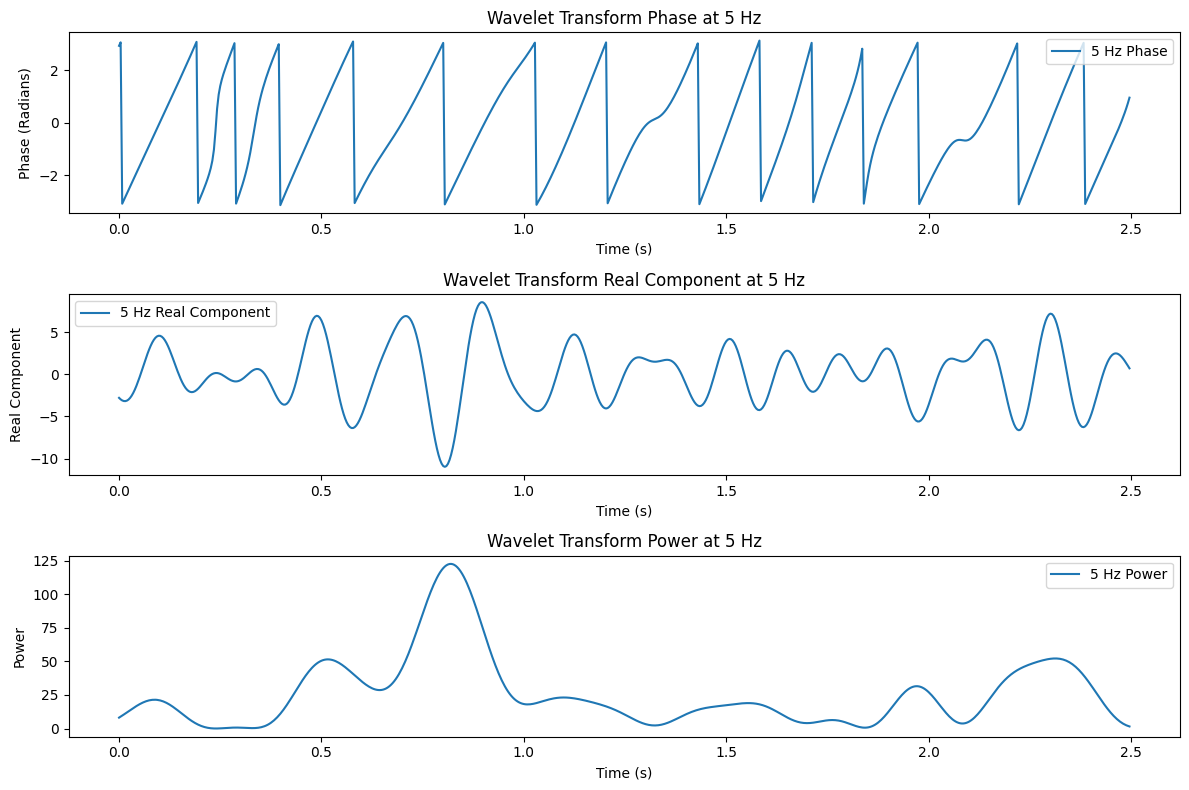

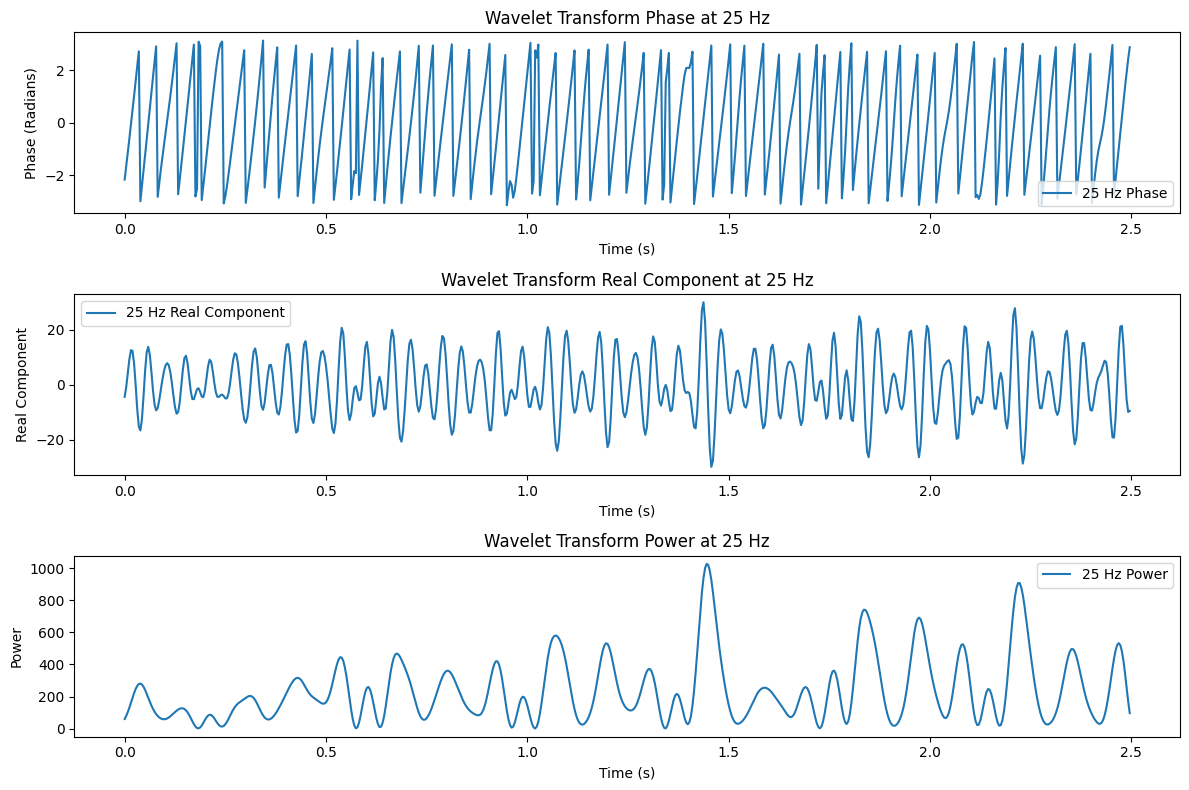

In [10]:
# Define the Morlet wavelet function
def morlet_wavelet(frequency, num_cycles, sampling_rate, wavelet_size):
    t = np.arange(-wavelet_size // 2, wavelet_size // 2 + 1) / sampling_rate
    sine_wave = np.exp(1j * 2 * np.pi * frequency * t)
    gaussian_window = np.exp(-t**2 / (2 * (num_cycles / (2 * np.pi * frequency))**2))
    wavelet = sine_wave * gaussian_window
    wavelet /= np.sqrt(np.sum(np.abs(wavelet)**2))  # Normalize wavelet
    return wavelet

# Perform wavelet convolution
def wavelet_convolution(data, wavelet):
    n_data = data.shape[0]
    n_wavelet = len(wavelet)
    n_convolution = n_data + n_wavelet - 1
    wavelet = np.conjugate(wavelet[::-1])
    
    # Perform the convolution using FFT
    data_fft = fft(data, n_convolution)
    wavelet_fft = fft(wavelet, n_convolution)
    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = ifft(convolution_result_fft)
    convolution_result = convolution_result[(n_wavelet//2):-(n_wavelet//2)]
    
    return convolution_result

# Define parameters for the Morlet wavelet
num_cycles = 4  # Fixed number of cycles in the wavelet
wavelet_size = 1000  # Define an arbitrary size for the wavelet

# Generate and convolve wavelets for each frequency of interest
wavelets = {freq: morlet_wavelet(freq, num_cycles, sampling_rate, wavelet_size) for freq in frequencies}
wavelet_transforms = {freq: wavelet_convolution(cz_data.flatten(), wavelets[freq]) for freq in frequencies}
wavelet_transforms_phase = {freq: np.angle(wavelet_transforms[freq]) for freq in frequencies}
wavelet_transforms_real = {freq: np.real(wavelet_transforms[freq]) for freq in frequencies}

# Plot the wavelet transform results for phase and real component
for freq in frequencies:
    plt.figure(figsize=(12, 8))
    
    # Phase plot
    plt.subplot(3, 1, 1)
    plt.plot(times, wavelet_transforms_phase[freq][:len(times)], label=f'{freq} Hz Phase')
    plt.xlabel('Time (s)')
    plt.ylabel('Phase (Radians)')
    plt.title(f'Wavelet Transform Phase at {freq} Hz')
    plt.legend()

    # Real component plot
    plt.subplot(3, 1, 2)
    plt.plot(times, wavelet_transforms_real[freq][:len(times)], label=f'{freq} Hz Real Component')
    plt.xlabel('Time (s)')
    plt.ylabel('Real Component')
    plt.title(f'Wavelet Transform Real Component at {freq} Hz')
    plt.legend()

    # Power plot
    plt.subplot(3, 1, 3)
    plt.plot(times, np.abs(wavelet_transforms[freq][:len(times)])**2, label=f'{freq} Hz Power')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.title(f'Wavelet Transform Power at {freq} Hz')
    plt.legend()

    plt.tight_layout()
    plt.show()
